<a href="https://colab.research.google.com/github/francji1/01NAEX/blob/main/code/01NAEX_exercise_02_Python_student_solution02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 01NAEX - Exercise 02 (Python)
This notebook combines the lecture example (originally prepared in Python) with the student assignment that was previously distributed as an R notebook. The goal is to keep all analysis and exercises in one Python environment.



## Lecture Example - Plasma Etch Rate Experiment
The lecture example investigates how the plasma etch rate responds to the radio-frequency (RF) power setting and to potential run-to-run variation. We will:
- explore and visualise the raw data,
- fit ANOVA models with and without the run factor,
- inspect model diagnostics,
- perform multiple comparisons (Tukey HSD and Fisher's LSD), and
- evaluate design power for several sample sizes.


In [1]:
# Core scientific Python stack for the example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.graphics.gofplots import qqplot

sns.set_theme(style="whitegrid")
np.set_printoptions(suppress=True)


In [2]:
# Load the plasma etch rate data used in the lecture example
ETCH_URL = "https://raw.githubusercontent.com/francji1/01NAEX/refs/heads/main/data/etchrate.txt"
etch_rate = pd.read_csv(ETCH_URL, delim_whitespace=True)

# Create categorical views that will be useful for the formulas
etch_rate = etch_rate.assign(
    Power=etch_rate["RF"].astype("category"),
    Run=etch_rate["run"].astype("category")
)

print("Rows, columns:", etch_rate.shape)
display(etch_rate.head())
etch_rate.describe(include="all")


/tmp/ipython-input-1323730227.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  etch_rate = pd.read_csv(ETCH_URL, delim_whitespace=True)


Rows, columns: (20, 5)


,RF,run,rate,Power,Run
0,160,1,575,160,1
1,160,2,542,160,2
2,160,3,530,160,3
3,160,4,539,160,4
4,160,5,570,160,5


,RF,run,rate,Power,Run
count,20.000000,20.000000,20.000000,20.0,20.0
unique,NaN,NaN,NaN,4.0,5.0
top,NaN,NaN,NaN,160.0,1.0
freq,NaN,NaN,NaN,5.0,4.0
mean,190.000000,3.000000,617.750000,NaN,NaN
std,22.941573,1.450953,61.648302,NaN,NaN
min,160.000000,1.000000,530.000000,NaN,NaN
25%,175.000000,2.000000,573.750000,NaN,NaN
50%,190.000000,3.000000,605.000000,NaN,NaN
75%,205.000000,4.000000,659.500000,NaN,NaN


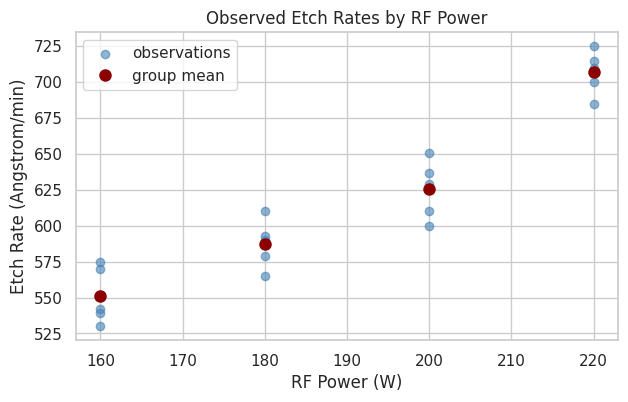

In [3]:
# Visual summary: scatter of observed rates with group means highlighted
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(etch_rate["RF"], etch_rate["rate"], color="steelblue", alpha=0.6, label="observations")
(
    etch_rate.groupby("RF")["rate"].mean()
    .plot(marker="o", color="darkred", linewidth=0, markersize=8, label="group mean", ax=ax)
)
ax.set_xlabel("RF Power (W)")
ax.set_ylabel("Etch Rate (Angstrom/min)")
ax.set_title("Observed Etch Rates by RF Power")
ax.legend()
plt.show()


/tmp/ipython-input-148346217.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=etch_rate, x="Power", y="rate", ax=axes[0], palette="Blues")
/tmp/ipython-input-148346217.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=etch_rate, x="Run", y="rate", ax=axes[1], palette="Greens")


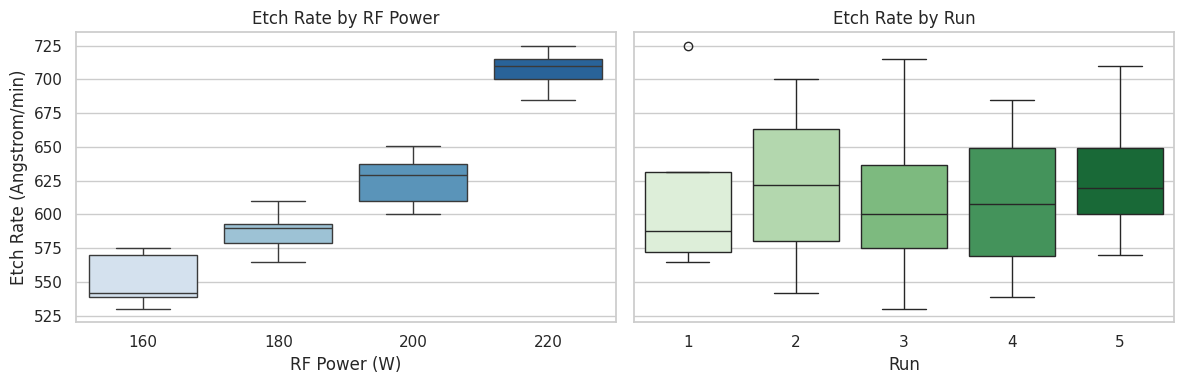

In [4]:
# Boxplots by RF power and by run to replicate the lecture visuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(data=etch_rate, x="Power", y="rate", ax=axes[0], palette="Blues")
axes[0].set_title("Etch Rate by RF Power")
axes[0].set_xlabel("RF Power (W)")
axes[0].set_ylabel("Etch Rate (Angstrom/min)")

sns.boxplot(data=etch_rate, x="Run", y="rate", ax=axes[1], palette="Greens")
axes[1].set_title("Etch Rate by Run")
axes[1].set_xlabel("Run")

plt.tight_layout()
plt.show()


In [5]:
# Fit single-factor and two-factor ANOVA models used in the lecture
model_power = ols("rate ~ C(Power)", data=etch_rate).fit()
model_power_no_intercept = ols("rate ~ C(Power) - 1", data=etch_rate).fit()
model_power_run = ols("rate ~ C(Power) + C(Run)", data=etch_rate).fit()

print(model_power.summary())


                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     66.80
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           2.88e-09
Time:                        07:19:55   Log-Likelihood:                -84.250
No. Observations:                  20   AIC:                             176.5
Df Residuals:                      16   BIC:                             180.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         551.2000      8.169     

In [6]:
# ANOVA tables (type II sums of squares) for both models
anova_power = sm.stats.anova_lm(model_power, typ=2)
anova_power_run = sm.stats.anova_lm(model_power_run, typ=2)

display(anova_power)
display(anova_power_run)

# Direct comparison of the nested models (Power-only vs Power + Run)
display(sm.stats.anova_lm(model_power, model_power_run))


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,66.797073,2.882866e-09
Residual,5339.20,16.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,62.369063,1.368674e-07
C(Run),1050.50,4.0,0.734838,5.856737e-01
Residual,4288.70,12.0,NaN,NaN


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,16.0,5339.2,0.0,NaN,NaN,NaN
1,12.0,4288.7,4.0,1050.5,0.734838,0.585674


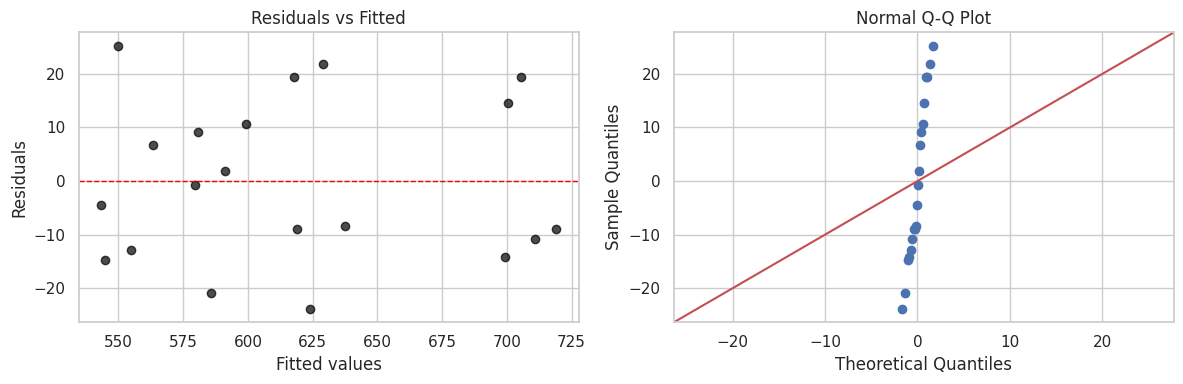

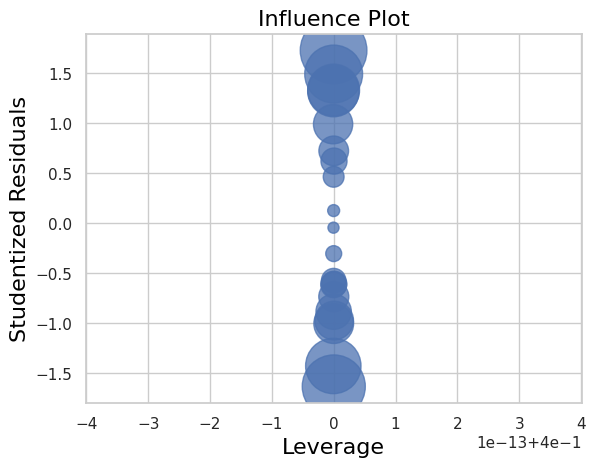

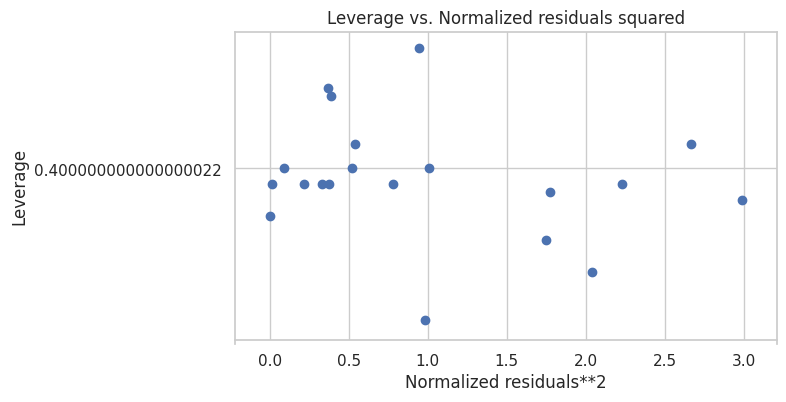

In [7]:
# Regression diagnostics mirroring the lecture content
residuals = model_power_run.resid
fitted = model_power_run.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(fitted, residuals, color="black", alpha=0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

qqplot(residuals, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

influence = OLSInfluence(model_power_run)
fig = influence.plot_influence(figsize=(8, 6))
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
sm.graphics.plot_leverage_resid2(model_power_run, ax=ax)
plt.show()


In [8]:
# Formal tests from the lecture (homogeneity, autocorrelation, etc.)
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)
bartlett_stat, bartlett_p = stats.bartlett(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)

bp_stat, bp_p, _, _ = het_breuschpagan(residuals, model_power_run.model.exog)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
print(f"Breusch-Pagan p:     {bp_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")


Shapiro-Wilk p-value: 0.317
Levene p-value:      0.898
Bartlett p-value:    0.443
Breusch-Pagan p:     0.038
Durbin-Watson stat:  2.854


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   160    180     36.2 0.0294   3.1456  69.2544   True
   160    200     74.2    0.0  41.1456 107.2544   True
   160    220    155.8    0.0 122.7456 188.8544   True
   180    200     38.0 0.0216   4.9456  71.0544   True
   180    220    119.6    0.0  86.5456 152.6544   True
   200    220     81.6    0.0  48.5456 114.6544   True
------------------------------------------------------


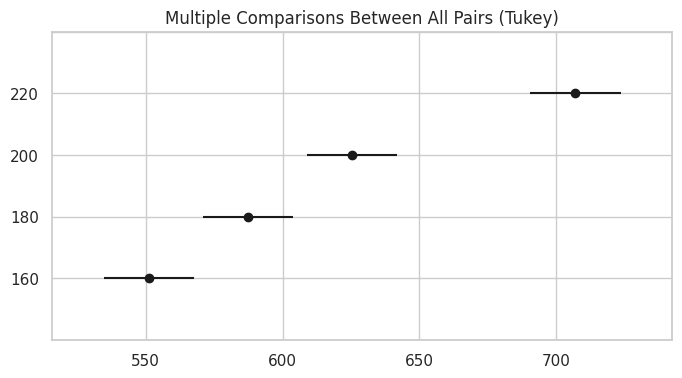

In [9]:
# Tukey HSD multiple comparisons (as demonstrated in the lecture)
tukey = pairwise_tukeyhsd(endog=etch_rate["rate"], groups=etch_rate["Power"], alpha=0.05)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8, 4))
plt.show()


In [10]:
# Fisher's LSD implementation with a compact letter display for quick interpretation
means = etch_rate.groupby("Power", observed=True)["rate"].mean()
counts = etch_rate.groupby("Power", observed=True)["rate"].count()
mse = anova_power_run.loc["Residual", "sum_sq"] / anova_power_run.loc["Residual", "df"]
df_error = anova_power_run.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means (Angstrom/min):")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
   if not labels[level]:
       labels[level] = chr(current_letter)
   for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
        current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
        print(f"Power {level}: mean={means[level]:.1f}, label={labels[level]}")


Least Significant Difference (alpha=0.05): 26.05
Group means (Angstrom/min):
Power
160    551.2
180    587.4
200    625.4
220    707.0
Name: rate, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Power 220: mean=707.0, label=A
Power 200: mean=625.4, label=D
Power 180: mean=587.4, label=G
Power 160: mean=551.2, label=J


,n per group,power
0,4,0.938481
1,5,0.991788
2,6,0.999172
3,7,0.999932
4,8,0.999995
5,9,1.000000
6,10,1.000000


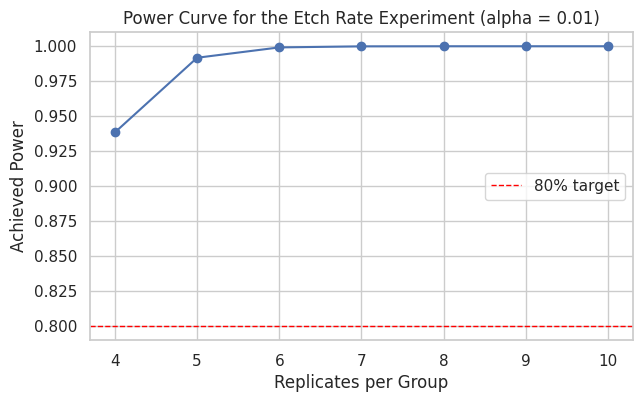

In [11]:
# Power exploration mirroring the lecture discussion
power_analysis = FTestAnovaPower()
alpha = 0.01
sigma = 25
max_diff = 75

cohen_f = (max_diff / 2) / sigma

sample_sizes = np.arange(4, 11)
power_values = [power_analysis.power(effect_size=cohen_f, nobs=n * 4, alpha=alpha, k_groups=4)
                for n in sample_sizes]

power_df = pd.DataFrame({"n per group": sample_sizes, "power": power_values})
display(power_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sample_sizes, power_values, marker="o")
ax.set_xlabel("Replicates per Group")
ax.set_ylabel("Achieved Power")
ax.set_title("Power Curve for the Etch Rate Experiment (alpha = 0.01)")
ax.axhline(0.8, color="red", linestyle="--", linewidth=1, label="80% target")
ax.legend()
plt.show()



## Student Assignment - Chapter 3 Exercises
Use the following cells to work through the problems. Each question mirrors the wording from the textbook; add your analysis in the empty code cells provided.



### Exercise 3.07 - Portland Cement Tensile Strength
Four mixing techniques are compared using a completely randomised design; tensile strength (lb/in^2) is recorded for four replicates at each technique.


In [12]:
# Data for Exercise 3.07
ex03_7 = pd.read_csv(
    "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_7.csv",
    sep=";"
)
ex03_7 = ex03_7.assign(Technique=ex03_7["Technique"].astype("category"))
cement = ex03_7.rename(columns={"Tensile_Strength": "strength"})
cement.head()


,Technique,strength
0,1,3129
1,1,3000
2,1,2865
3,1,2890
4,2,3200


**Question 1.** Construct graphical displays that compare the mean tensile strengths for the four mixing techniques.

/tmp/ipython-input-58875338.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax.plot(cement.groupby("Technique")["strength"].mean(), marker="o", color="darkred",


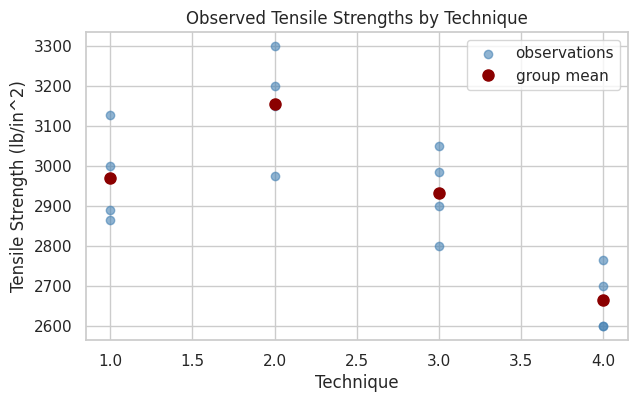

In [13]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(cement["Technique"], cement["strength"], color="steelblue", alpha=0.6, label="observations")
ax.plot(cement.groupby("Technique")["strength"].mean(), marker="o", color="darkred",
        linewidth=0, markersize=8, label="group mean")
ax.set_xlabel("Technique")
ax.set_ylabel("Tensile Strength (lb/in^2)")
ax.set_title("Observed Tensile Strengths by Technique")
ax.legend()
plt.show()

**Question 2.** Test at alpha = 0.05 whether mixing technique affects tensile strength.

In [37]:
# Model fit
fitted = ols("strength ~ C(Technique)", data=cement).fit()
fitted_no_intercept = ols("strength ~ C(Technique) - 1", data=cement).fit()
print(fitted.summary())

anova_table = sm.stats.anova_lm(fitted, typ=2)
display(anova_table)

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     12.73
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           0.000489
Time:                        07:23:55   Log-Likelihood:                -96.075
No. Observations:                  16   AIC:                             200.2
Df Residuals:                      12   BIC:                             203.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2971.0000     56.62

,sum_sq,df,F,PR(>F)
C(Technique),489740.1875,3.0,12.728107,0.000489
Residual,153908.2500,12.0,NaN,NaN


In [46]:
fitted_anova = sm.stats.anova_lm(fitted, typ=2)
display(fitted_anova)
mse = fitted.mse_resid
mse

,sum_sq,df,F,PR(>F)
C(Technique),489740.1875,3.0,12.728107,0.000489
Residual,153908.2500,12.0,NaN,NaN


np.float64(12825.6875)

##### **Comment on question 2:**
The results of the ANOVA test show that we reject the null hypothesis.

Therefore, we can say that mixing techniques **affect** tensile strength.

**Question 3.** Use Fisher's LSD method with alpha = 0.05 to make pairwise comparisons between techniques.

In [43]:
means = cement.groupby("Technique", observed=True)["strength"].mean()
counts = cement.groupby("Technique", observed=True)["strength"].count()
mse = anova_power_run.loc["Residual", "sum_sq"] / anova_power_run.loc["Residual", "df"]
df_error = anova_power_run.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())


print("Fisher's Least Significant Difference (LSD) Method")
print("="*60)
print(f"Alpha: {alpha}")
print(f"MSE: {mse:.4f}")
print(f"Degrees of freedom (error): {df_error}")
print(f"Critical t-value: {t_crit:.4f}")
print(f"LSD = {lsd:.4f}")
print("\n" + "="*60)



print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means (lb/in^2):")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
    if not labels[level]:
        labels[level] = chr(current_letter)
    for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
        current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
    print(f"Technique {level}: mean={means[level]:.1f}, label={labels[level]}")

Fisher's Least Significant Difference (LSD) Method
Alpha: 0.05
MSE: 357.3917
Degrees of freedom (error): 12.0
Critical t-value: 2.1788
LSD = 29.1258

Least Significant Difference (alpha=0.05): 29.13
Group means (lb/in^2):
Technique
1    2971.00
2    3156.25
3    2933.75
4    2666.25
Name: strength, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Technique 2: mean=3156.2, label=A
Technique 1: mean=2971.0, label=D
Technique 3: mean=2933.8, label=G
Technique 4: mean=2666.2, label=J


##### **Comment on question 3:**
All mixing techniques have statistically significant different mean tensile strengths

**Question 4.** Construct a normal probability plot of the residuals. Does the normality assumption appear reasonable?

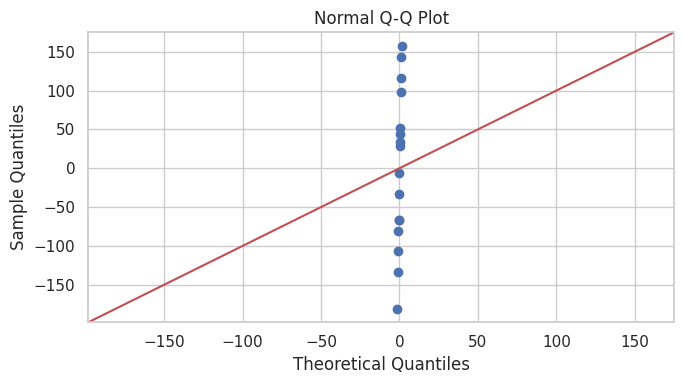

In [50]:
residuals = fitted_no_intercept.resid
fitted = fitted_no_intercept.fittedvalues

fig, ax = plt.subplots(figsize=(7, 4))
qqplot(residuals, line="45", ax=ax)
ax.set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

In [17]:
# Other formal tests from the lecture
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["strength"].values for _, group in cement.groupby("Technique", observed=True)]
)
barlett_stat, bartlett_p = stats.bartlett(
    *[group["strength"].values for _, group in cement.groupby("Technique", observed=True)]
)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")

Shapiro-Wilk p-value: 0.846
Levene p-value:      0.906
Bartlett p-value:    0.531
Durbin-Watson stat:  2.050


##### **Comments on question 4:**
Shapiro: We **do not reject** the null hypothesis ~ normally distributed

Levene: We **do not reject** the null hypothesis ~ equal variance

Barlett: Same as Levene

Durbin: Test supports the assumption of independent residuals (close to 2)


**Question 5.** Plot the residuals versus the fitted tensile strength and comment.

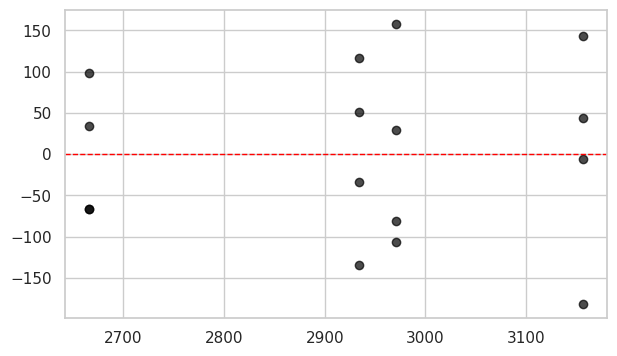

In [18]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(fitted, residuals, color="black", alpha=0.7)
ax.axhline(0, color="red", linestyle="--", linewidth=1)

##### **Comments on question 5:**
No clear fanning-out/fanning-in. No clear systematic pattern.

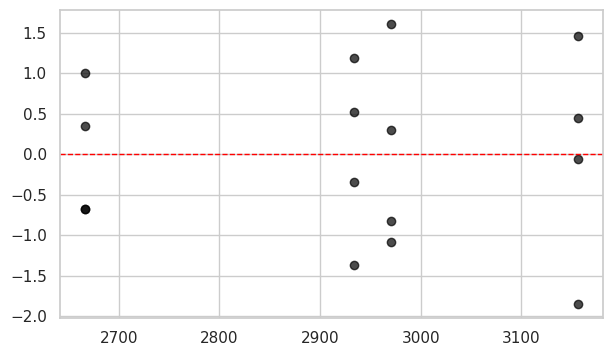

In [19]:
influence = fitted_no_intercept.get_influence()
studentized_residuals = influence.resid_studentized_internal
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(fitted, studentized_residuals, color="black", alpha=0.7)
ax.axhline(0, color="red", linestyle="--", linewidth=1)


**Question 6.** Prepare a scatter plot of the raw observations to aid interpretation.

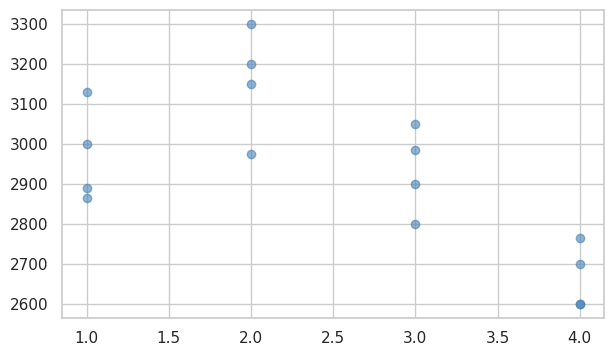

In [20]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(cement["Technique"], cement["strength"], color="steelblue", alpha=0.6, label="observations")


### Exercises 3.08 and 3.09 - Follow-Up Comparisons
We revisit the Portland cement experiment to explore multiple comparisons and confidence intervals.


**Question 1.** Rework the pairwise comparisons using Tukey's test with alpha = 0.05. Do the conclusions match the graphical procedure and Fisher's LSD?

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower     upper   reject
--------------------------------------------------------
     1      2   185.25 0.1494  -52.5003  423.0003  False
     1      3   -37.25 0.9653 -275.0003  200.5003  False
     1      4  -304.75 0.0116 -542.5003  -66.9997   True
     2      3   -222.5 0.0693 -460.2503   15.2503  False
     2      4   -490.0 0.0003 -727.7503 -252.2497   True
     3      4   -267.5 0.0262 -505.2503  -29.7497   True
--------------------------------------------------------


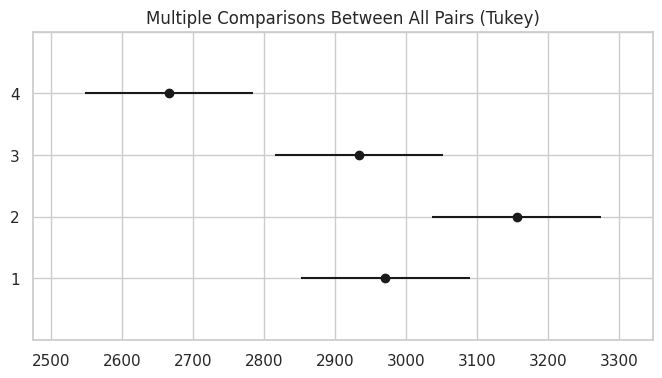

In [21]:
tukey = pairwise_tukeyhsd(endog=cement["strength"], groups=cement["Technique"], alpha=0.05)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8, 4))
plt.show()

##### **Comments on question 1:**
Statistically significant difference shown for pairs:
*   Tech 1 and Tech 4
*   Tech 2 and Tech 4
*   Tech 3 and Tech 4

Fisher LSD indicated that all pairs have statistically significant different mean tensile strength

If one would like to control the **Type I error** (preffered), the results given from **Tukey are preffered**



**Question 2.** Explain the difference between Tukey's procedure and Fisher's LSD.


#### **Fisher**

*   series of independent t-tests between all pairs
*   controls comparison-wise error rate = Type I per comparison

#### **Tukey**

*   essentially a t-test that correct for family-wise error rate
*   controls family-wise error rate = Type I for all comparisons at once
*   better if we want to control the overall Type I error rate





**Question 3.** Find 95 percent confidence intervals for each technique mean and for the difference between techniques 1 and 3. How do these intervals aid interpretation?

In [22]:
# Get necessary values from the fitted model and ANOVA table
means = cement.groupby("Technique", observed=True)["strength"].mean()
mse = anova_table.loc["Residual", "sum_sq"] / anova_table.loc["Residual", "df"]
df_error = anova_table.loc["Residual", "df"]
n_per_group = cement.groupby("Technique", observed=True)["strength"].count().iloc[0]

# Calculate 95% CI for each technique mean
alpha_95 = 0.05
t_crit_95 = stats.t.ppf(1 - alpha_95 / 2, df_error)
se_mean = np.sqrt(mse / n_per_group)
margin_of_error_95 = t_crit_95 * se_mean

print("95% Confidence Intervals for each Technique Mean:")
for technique, mean in means.items():
    ci_lower = mean - margin_of_error_95
    ci_upper = mean + margin_of_error_95
    print(f"  Technique {technique}: ({ci_lower:.2f}, {ci_upper:.2f})")

# Calculate 99% CI for the mean difference between techniques 1 and 3
mean_diff_1_3 = means[1] - means[3]
alpha_99 = 0.01
t_crit_99 = stats.t.ppf(1 - alpha_99 / 2, df_error)
se_diff = np.sqrt(mse * (1/n_per_group + 1/n_per_group))
margin_of_error_99 = t_crit_99 * se_diff

ci_diff_1_3_lower = mean_diff_1_3 - margin_of_error_99
ci_diff_1_3_upper = mean_diff_1_3 + margin_of_error_99

print(f"\n99% Confidence Interval for Mean Difference (Technique 1 - Technique 3): ({ci_diff_1_3_lower:.2f}, {ci_diff_1_3_upper:.2f})")

95% Confidence Intervals for each Technique Mean:
  Technique 1: (2847.62, 3094.38)
  Technique 2: (3032.87, 3279.63)
  Technique 3: (2810.37, 3057.13)
  Technique 4: (2542.87, 2789.63)

99% Confidence Interval for Mean Difference (Technique 1 - Technique 3): (-207.36, 281.86)



### Exercise 3.10 - Cotton Content Experiment
Synthetic fibre tensile strength is measured at five cotton-content levels with five replicates each.


In [23]:
# Data for Exercise 3.10
ex03_10 = pd.read_csv(
    "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_10.csv",
    sep=";"
).rename(columns={"Cotton_Weight ": "Cotton_Weight", "Observations": "strength"})
ex03_10 = ex03_10.assign(Cotton_Weight=ex03_10["Cotton_Weight"].astype("category"))
ex03_10.head()


,Cotton_Weight,strength
0,15,7
1,20,12
2,25,14
3,30,19
4,35,7


**Question 1.** Test at alpha = 0.05 whether cotton content affects mean fibre strength.

In [24]:
model_cotton = ols("strength ~ C(Cotton_Weight)", data=ex03_10).fit()
anova_cotton = sm.stats.anova_lm(model_cotton, typ=2)

print("ANOVA table for Cotton Content vs Fibre Strength:")
display(anova_cotton)

ANOVA table for Cotton Content vs Fibre Strength:


,sum_sq,df,F,PR(>F)
C(Cotton_Weight),475.76,4.0,14.756824,0.000009
Residual,161.20,20.0,NaN,NaN


##### **Comments on question 1:**
We reject the null hypothesis -> there is a statistically significant difference in the mean strength among the different cotton weights


**Question 2.** Use Fisher's LSD (alpha = 0.05) to compare the mean strengths across cotton levels.

In [25]:
means = ex03_10.groupby("Cotton_Weight", observed=True)["strength"].mean()
counts = ex03_10.groupby("Cotton_Weight", observed=True)["strength"].count()
mse = anova_cotton.loc["Residual", "sum_sq"] / anova_cotton.loc["Residual", "df"]
df_error = anova_cotton.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means:")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
    if not labels[level]:
        labels[level] = chr(current_letter)
    for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
    current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
    print(f"Cotton Weight {level}: mean={means[level]:.1f}, label={labels[level]}")

Least Significant Difference (alpha=0.05): 3.75
Group means:
Cotton_Weight
15     9.8
20    15.4
25    17.6
30    21.6
35    10.8
Name: strength, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Cotton Weight 30: mean=21.6, label=A
Cotton Weight 25: mean=17.6, label=B
Cotton Weight 20: mean=15.4, label=B
Cotton Weight 35: mean=10.8, label=D
Cotton Weight 15: mean=9.8, label=D


##### **Comments on question 2:**
Cotton weights 25 and 20 are not statistically different from each other. Same for 35 and 15.


**Question 3.** Analyse residuals and comment on model adequacy.

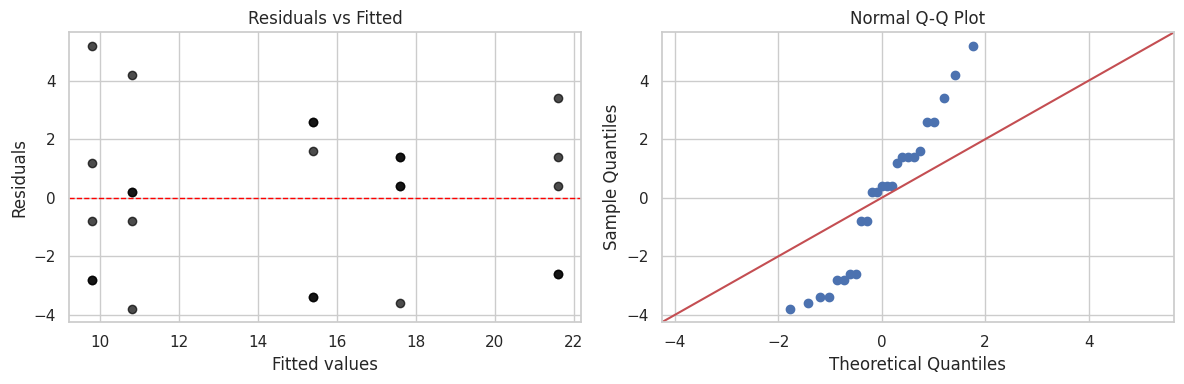

Shapiro-Wilk p-value: 0.182
Levene p-value:      0.863
Bartlett p-value:    0.533
Durbin-Watson stat:  1.773


In [26]:
residuals = model_cotton.resid
fitted = model_cotton.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(fitted, residuals, color="black", alpha=0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

qqplot(residuals, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

# Formal tests
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["strength"].values for _, group in ex03_10.groupby("Cotton_Weight", observed=True)]
)
bartlett_stat, bartlett_p = stats.bartlett(
    *[group["strength"].values for _, group in ex03_10.groupby("Cotton_Weight", observed=True)]
)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")

##### **Comments on question 3:**
Residuals indicate no sign of fanning-in/out. Scatter is somewhat random.

Shapiro: Test results supports the fact that we do not have enough evidence to reject the null hypothesis.

Levene, Bartlett: We cannot reject the null hypothsis of equal variances

Durbin: ~2, maybe there is some positive autocorrelation, but not significant

### Exercise 3.18 and 3.19

A manufacturer of television sets is interested in the effect on tube conductivity of four different types of coating for color picture tubes.  
A completely randomized experiment is conducted and the following conductivity data are obtained:

| Coating Type | Conductivity              |
|--------------|---------------------------|
| 1            | 143, 141, 150, 146        |
| 2            | 152, 149, 137, 143        |
| 3            | 134, 136, 132, 127        |
| 4            | 129, 127, 132, 129        |

**Question 1.**  Is there a difference in conductivity due to coating type? Use α = 0.05.  

**Question 2.**  Estimate the overall mean and the treatment effects.  

**Question 3.** Compute a 95 percent confidence interval estimate of the mean of coating type 4.  
Compute a 99 percent confidence interval estimate of the mean difference between coating types 1 and 4.  

**Question 4.**  Test all pairs of means using the Fisher LSD method with α = 0.05.  

**Question 5.**  Use the graphical method discussed in Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?  

**Question 6.**  Assuming that coating type 4 is currently in use, what are your recommendations to the manufacturer?  
We wish to minimize conductivity.  

**Question 7.**  
Analyze the residuals and draw conclusions about model adequacy.

In [27]:
conductivity_data = [143, 141, 150, 146, 152, 149, 137, 143, 134, 136, 132, 127, 129, 127, 132, 129]
coating_types = [1] * 4 + [2] * 4 + [3] * 4 + [4] * 4

data = {"Conductivity": conductivity_data, "Coating_Type": coating_types}
coating_data = pd.DataFrame(data)
coating_data["Coating_Type"] = coating_data["Coating_Type"].astype("category")

display(coating_data.head())

,Conductivity,Coating_Type
0,143,1
1,141,1
2,150,1
3,146,1
4,152,2


**Question 1.** Is there a difference in conductivity due to coating type? Use alpha = 0.05.

In [28]:
model_coating = ols("Conductivity ~ C(Coating_Type)", data=coating_data).fit()
anova_coating = sm.stats.anova_lm(model_coating, typ=2)

print("ANOVA table for Coating Type vs Conductivity:")
display(anova_coating)

ANOVA table for Coating Type vs Conductivity:


,sum_sq,df,F,PR(>F)
C(Coating_Type),844.6875,3.0,14.301587,0.000288
Residual,236.2500,12.0,NaN,NaN


##### **Comments on question 1:**
Yes, there is. We reject the null hypothesis.

**Question 2.** Estimate the overall mean and the treatment effects.

In [29]:
overall_mean = coating_data["Conductivity"].mean()
group_means = coating_data.groupby("Coating_Type")["Conductivity"].mean()
treatment_effects = group_means - overall_mean

print(f"Overall Mean Conductivity: {overall_mean:.2f}")
print("\nTreatment Effects (Mean Conductivity - Overall Mean):")
for coating_type, effect in treatment_effects.items():
    print(f"  Coating Type {coating_type}: {effect:.2f}")

Overall Mean Conductivity: 137.94

Treatment Effects (Mean Conductivity - Overall Mean):
  Coating Type 1: 7.06
  Coating Type 2: 7.31
  Coating Type 3: -5.69
  Coating Type 4: -8.69


/tmp/ipython-input-1913139244.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = coating_data.groupby("Coating_Type")["Conductivity"].mean()


**Question 3.** Compute a 95% confidence interval for the mean of coating type 4 and a 99% confidence interval for the mean difference between coatings 1 and 4.

In [30]:
mean_type4 = coating_data[coating_data["Coating_Type"] == 4]["Conductivity"].mean()
n_type4 = coating_data[coating_data["Coating_Type"] == 4]["Conductivity"].count()
mse = anova_coating.loc["Residual", "sum_sq"] / anova_coating.loc["Residual", "df"]
df_error = anova_coating.loc["Residual", "df"]

se_type4 = np.sqrt(mse / n_type4)
t_crit_95 = stats.t.ppf(1 - 0.05 / 2, df_error)
ci_type4_lower = mean_type4 - t_crit_95 * se_type4
ci_type4_upper = mean_type4 + t_crit_95 * se_type4

print(f"95% Confidence Interval for Mean Conductivity of Coating Type 4: ({ci_type4_lower:.2f}, {ci_type4_upper:.2f})")

# Calculate 99% CI for the mean difference between coating types 1 and 4
mean_type1 = coating_data[coating_data["Coating_Type"] == 1]["Conductivity"].mean()
n_type1 = coating_data[coating_data["Coating_Type"] == 1]["Conductivity"].count()
mean_diff_1_4 = mean_type1 - mean_type4

se_diff_1_4 = np.sqrt(mse * (1/n_type1 + 1/n_type4))
t_crit_99 = stats.t.ppf(1 - 0.01 / 2, df_error)
ci_diff_1_4_lower = mean_diff_1_4 - t_crit_99 * se_diff_1_4
ci_diff_1_4_upper = mean_diff_1_4 + t_crit_99 * se_diff_1_4

print(f"99% Confidence Interval for Mean Difference (Type 1 - Type 4): ({ci_diff_1_4_lower:.2f}, {ci_diff_1_4_upper:.2f})")

95% Confidence Interval for Mean Conductivity of Coating Type 4: (124.42, 134.08)
99% Confidence Interval for Mean Difference (Type 1 - Type 4): (6.17, 25.33)


**Question 4.** Test all pairs of means using the Fisher LSD method with alpha = 0.05.

In [31]:
means = coating_data.groupby("Coating_Type", observed=True)["Conductivity"].mean()
counts = coating_data.groupby("Coating_Type", observed=True)["Conductivity"].count()
mse = anova_coating.loc["Residual", "sum_sq"] / anova_coating.loc["Residual", "df"]
df_error = anova_coating.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means (Conductivity):")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
    if not labels[level]:
        labels[level] = chr(current_letter)
    for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
        current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
    print(f"Coating Type {level}: mean={means[level]:.1f}, label={labels[level]}")

Least Significant Difference (alpha=0.05): 6.84
Group means (Conductivity):
Coating_Type
1    145.00
2    145.25
3    132.25
4    129.25
Name: Conductivity, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Coating Type 2: mean=145.2, label=A
Coating Type 1: mean=145.0, label=A
Coating Type 3: mean=132.2, label=G
Coating Type 4: mean=129.2, label=G


##### **Comments on question 4:**
There is a statistcal sig. difference between two groups (1,2) x (3,4)

**Question 5.** Use the graphical method from Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?

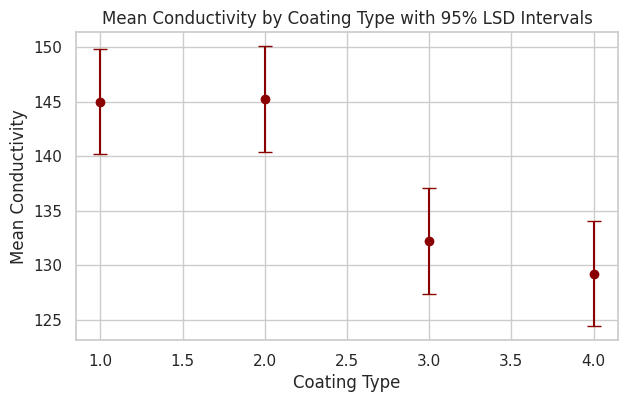

In [32]:
# TODO: create the plot of means with LSD intervals
se = np.sqrt(mse / counts.mean())
margin_of_error = t_crit * se

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(means.index, means.values, yerr=margin_of_error, fmt='o', capsize=5, color='darkred')
ax.set_xlabel("Coating Type")
ax.set_ylabel("Mean Conductivity")
ax.set_title("Mean Conductivity by Coating Type with 95% LSD Intervals")
plt.show()

##### **Comments on question 5:**
Coating type number 2 produces the highest conductivity.


**Question 6.** Assuming coating type 4 is currently in use and conductivity should be minimised, what is your recommendation?

Based on the analysis above, there is no significant difference if we switch to coating number 3. Usage of coating 1,2 is discouraged.

There is no statistical evidence to recommend switching from coating number 4 to another coating type.

**Question 7.** Analyse the residuals and comment on model adequacy.

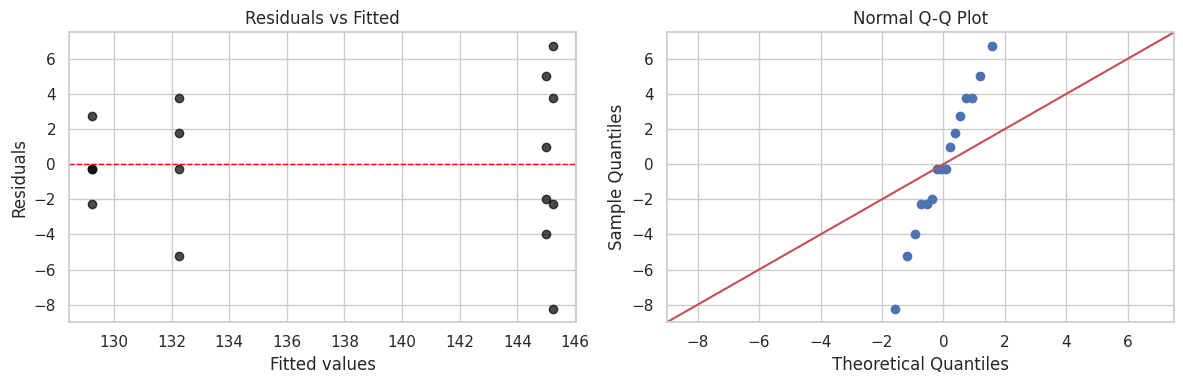

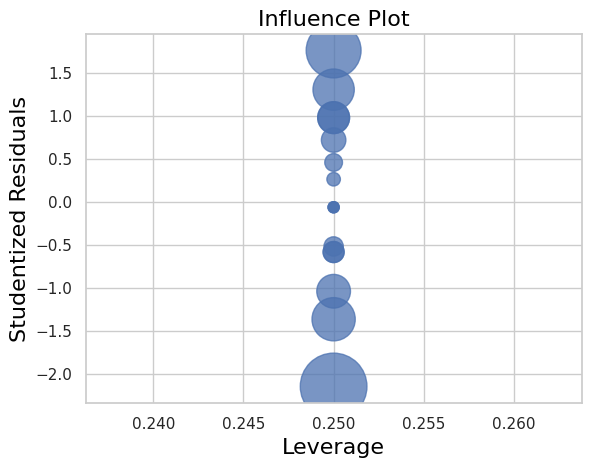

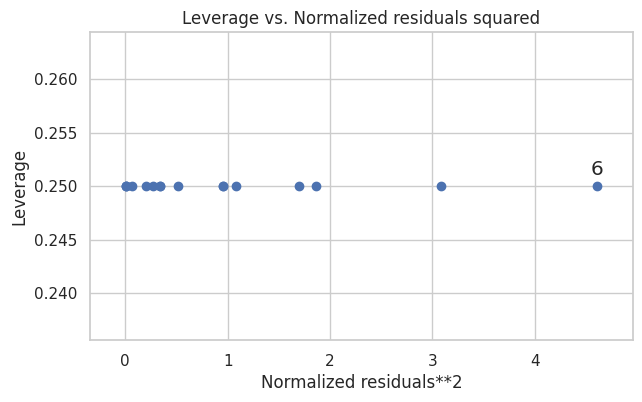

In [33]:
residuals = model_coating.resid
fitted = model_coating.fittedvalues

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(fitted, residuals, color="black", alpha=0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

qqplot(residuals, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

influence = OLSInfluence(model_coating)
fig = influence.plot_influence(figsize=(8,6))
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
sm.graphics.plot_leverage_resid2(model_coating, ax=ax)
plt.show()

In [34]:
# Formal tests
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["Conductivity"].values for _, group in coating_data.groupby("Coating_Type", observed=True)]
    )
bartlett_stat, bartlett_p = stats.bartlett(
    *[group["Conductivity"].values for _, group in coating_data.groupby("Coating_Type", observed=True)]
    )
# bp_stat, bp_p, _, _ = het_breuschpagan(residuals, fitted_no_intercept.model.exog)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
# print(f"Breusch-Pagan p:     {bp_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")

Shapiro-Wilk p-value: 0.988
Levene p-value:      0.140
Bartlett p-value:    0.253
Durbin-Watson stat:  1.892


##### **Comments on question 7:**
Residuals appear scattered, no obvious pattern or fanning.

Q-Q plot and shapiro test support the assumption of normaly distributed data.

Based on Levene and Bartlett we do not have enough evidence to reject H_0 - equal variance

Durbin is close to 2, no significant positive or negative autocorrelation.

The model would be adequate.